#### The selection follows [Supporting Document:  The Search for Resonant HH Production Decaying to the4b Final State Using the Full Run-2 Data and the Boosted Analysis Channel](https://cds.cern.ch/record/2708599)

In [247]:
import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib
import time
from tqdm import tqdm



from BranchClass import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


## Define Function for Invariant Mass, Transverse Mass


In [248]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

def Mbbbb(j1,j2,j3,j4):
    pt1, eta1, phi1, m1 = j1.pt,j1.eta,j1.phi,j1.mass
    pt2, eta2, phi2, m2 = j2.pt,j2.eta,j2.phi,j2.mass
    pt3, eta3, phi3, m3 = j3.pt,j3.eta,j3.phi,j3.mass
    pt4, eta4, phi4, m4 = j4.pt,j4.eta,j4.phi,j4.mass
    
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px3, py3, pz3 = pt3*np.cos(phi3), pt3*np.sin(phi3), np.sqrt(m3**2+pt3**2)*np.sinh(eta3)
    e3 = np.sqrt(m3**2 + px3**2 + py3**2 + pz3**2)
    px4, py4, pz4 = pt4*np.cos(phi4), pt4*np.sin(phi4), np.sqrt(m4**2+pt4**2)*np.sinh(eta4)
    e4 = np.sqrt(m4**2 + px4**2 + py4**2 + pz4**2)
    
    return np.sqrt((e1+e2+e3+e4)**2-(px1+px2+px3+px4)**2-(py1+py2+py3+py4)**2-(pz1+pz2+pz3+pz4)**2)

def MJJ(j1,j2):
    pt1, eta1, phi1, m1 = j1.pt,j1.eta,j1.phi,j1.mass
    pt2, eta2, phi2, m2 = j2.pt,j2.eta,j2.phi,j2.mass
    
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)


def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2,missingET,missingETA,missingPHI):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px_missing, py_missing = missingET*np.cos(missingPHI), missingET*np.sin(missingPHI)
    
    EllT = np.sqrt((px1+px2)**2 + (py1+py2)**2 +  M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2)**2 )

    MT = np.sqrt( (EllT+missingET)**2 - (px1+px2+px_missing)**2 - (py1+py2+py_missing)**2 )
    
    return MT
    
def PxPyPzE(pt,eta,phi,m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), np.sqrt(m**2+pt**2)*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    
    return px, py, pz, e    

def PtEtaPhiM(px, py, pz, e):
    E, px ,py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m

def ET(jet):
    pt = jet.pt
    m = jet.mass
    ET = np.sqrt(m**2 + pt**2)
    return  ET


def XHH(jet1, jet2):
    m1, m2 = jet1.mass, jet2.mass
    XHH = np.sqrt( (m1-124)**2/(0.1*m1) + (m2-115)**2/(0.1*m2))
    return  XHH

def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourVectorbb(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    m = np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    pt = np.sqrt((px1+px2)**2 + (py1+py2)**2)
    eta = np.arcsinh((pz1+pz2)/np.sqrt(m**2+pt**2))
    phi = np.arcsin((py1+py2)/pt)
    
    return pt, eta, phi, m


def jet_trim(jet0, pt_cut= 0.05, R1 = 0.2):
    # Define a cut threshold that the subjets have to meet (i.e. 3% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = pyjet.cluster(jet0.constituents_array(), R=R1, p=1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    subjet_array = subjets.inclusive_jets()
    j0 = []
    if (subjet_array[0].pt >= jet0_cut):
        for ij, subjet in enumerate(subjet_array):
            if subjet.pt < jet0_cut:
                # subjet doesn't meet the percentage cut on the original jet pT
                continue
            if subjet.pt >= jet0_cut:
                # Get the subjets pt, eta, phi constituents
                subjet_data = subjet.constituents_array()
                j0.append(subjet_data)
    else:
        j0 = subjet_array[0].constituents_array()*0
    jet = j0[0]
    for i, subjet in enumerate(j0):
        if i==0 :
            continue
        jet = np.append(jet, subjet)
        
    sequence = pyjet.cluster(jet, R=1.0, p=-1)
    jet = sequence.inclusive_jets()
    return jet


def digit(loc,pid):
    #     //  PID digits (base 10) are: n nr nl nq1 nq2 nq3 nj
    #     //   nj = 1, nq3=2 , nq2=3, nq1, nl, nr, n, n8, n9, n10 
    #     //  the location enum provides a convenient index into the PID
    numerator = 10**(loc-1)
    
    return int((abs(pid)/numerator)%10)

def hasBottom(pid):
    # get B hadron
    # PID for B hadron are 5XX, 5XXX
    # https://gitlab.com/hepcedar/rivet/-/blob/release-3-1-x/analyses/pluginCMS/CMS_2015_I1370682.cc#L390
    # https://rivet.hepforge.org/code/2.1.0/a00827.html#ad4c917595339ea52152c2950ce1225e7
    # https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    if( digit(2,pid) == 5 or digit(3,pid) == 5 or digit(4,pid) == 5 ):
        return True
    else:
        return False


## Import File

In [249]:
path = "/home/u5/Universality_DiHiggs/"

process_path_herwig_angular_H = path + "Herwig_angular/ppHhh_herwig_ang_1.root"
# process_path_pythia_default_H =  path + "Pythia_default/ppHhh_pythia_def_1.root"
# process_path_pythia_vincia_H = path + "Pythia_vincia/ppHhh_pythia_vin_1.root"
# process_path_pythia_dipole_H = path + "Pythia_dipole/ppHhh_pythia_dip_1.root"
# process_path_sherpa = "./Data_root/ppwz_sherpa.root"

process_path_herwig_angular_QCD = path + "Herwig_angular/ppbbbb_herwig_ang_1.root"
# process_path_pythia_default_QCD = path + "Pythia_default/ppbbbb_pythia_def_1.root"
# process_path_pythia_vincia_QCD = path + "Pythia_vincia/ppbbbb_pythia_vin_1.root"
# process_path_pythia_dipole_QCD = path + "Pythia_dipole/ppbbbb_pythia_dip_1.root"
# process_path_sherpa_QCD = "./Data_root/ppjj_sherpa.root"




try:
    herwig_angular_H = uproot.open(process_path_herwig_angular_H)["Delphes;1"]
#     pythia_default_H = uproot.open(process_path_pythia_default_H)["Delphes;1"]
#     pythia_vincia_H = uproot.open(process_path_pythia_vincia_H)["Delphes;1"]
#     pythia_dipole_H = uproot.open(process_path_pythia_dipole_H)["Delphes;1"]
#     sherpa = uproot.open(process_path_sherpa)["Delphes;1"]
    
    herwig_angular_QCD = uproot.open(process_path_herwig_angular_QCD)["Delphes;1"]
#     pythia_default_QCD = uproot.open(process_path_pythia_default_QCD)["Delphes;1"]
#     pythia_vincia_QCD = uproot.open(process_path_pythia_vincia_QCD)["Delphes;1"]
#     pythia_dipole_QCD = uproot.open(process_path_pythia_dipole_QCD)["Delphes;1"]
#     sherpa_QCD = uproot.open(process_path_sherpa_QCD)["Delphes;1"]
    
    
#     process_list = [pythia_default, pythia_vincia, pythia_dipole]
    
    print("All Files are loaded!")
    
except:
    print("Please Check Input Files")


All Files are loaded!


#  Print the Branch in the Delphes

In [250]:
# herwig_angular_H.show()

In [251]:
def Event_List(GenParticle):
#     print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    k = 0
    bbbb_list = []
    event_list = []
    bb1_P4, bb2_P4 = [], []
    Mbbbb = []
    bhadron_list = []
    for N in tqdm(range(GenParticle.length)):

        event_list_tmp = []

        event_list_tmp.append([GenParticle.PT_At(N),  GenParticle.Eta_At(N), \
                               GenParticle.Phi_At(N), GenParticle.Mass_At(N), \
                               GenParticle.PID_At(N), GenParticle.Status_At(N),\
                               GenParticle.Charge_At(N),\
                               np.full(len(GenParticle.PT_At(N)),0), #for B hadron tag
                               GenParticle.M1_At(N), GenParticle.M2_At(N),\
                               GenParticle.D1_At(N), GenParticle.D2_At(N),\
                               

                              ])
        
        event_list_tmp = np.array(event_list_tmp)
        
    
        """
        Find All B Hadrons
        """
        unstable_hadron = event_list_tmp[0][:,np.abs(event_list_tmp[0][5,:])==2]
        bhadron_index = np.where(np.vectorize(hasBottom)(unstable_hadron[4,:])==True)[0] 
        bhadron = unstable_hadron[:,bhadron_index]
        bhadron_list_tmp = []
        
        """
        Find B Hadrons before decay
        """
        for i in range(len(bhadron[0])):   
            if hasBottom(GenParticle.PID_At(N)[int(bhadron[10][i])]) == False and hasBottom(GenParticle.PID_At(N)[int(bhadron[11][i])]) == False:
                bhadron_list_tmp.append(bhadron[:,i])
        
        """
        Ghost Association Method
        """
        Ghostparam = 1E-20
        for i, element in enumerate(bhadron_list_tmp):
            bhadron_list_tmp[i][0] = element[0]*Ghostparam  # PT*Ghostparam
            bhadron_list_tmp[i][3] = element[3]*Ghostparam  # Mass*Ghostparam
            bhadron_list_tmp[i][7] = 1                      #B Hadron tag 
        
        """
        Pick stable final state particel (status = 1) and filter ou neutrinos (|PID| = 12, 14, 16)
        """
        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1] 
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=12]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=14]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=16]
        
        event_list_tmp = np.concatenate((np.array(event_list_tmp).transpose(),bhadron_list_tmp)).transpose()
        
        event_list.append(event_list_tmp)
        
        
#         k += 1
#         if k == 1000:
#             break
        
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    return event_list

## Load event via class

In [252]:
# importlib.reload(BranchClass)

GenParticle_herwig_angular_H = BranchGenParticles(herwig_angular_H)
Event_List_herwig_angular_H = Event_List(GenParticle_herwig_angular_H)

# GenParticle_pythia_default_H = BranchGenParticles(pythia_default_H)
# Event_List_pythia_default_H = Event_List(GenParticle_pythia_default_H)

# GenParticle_pythia_vincia_H = BranchGenParticles(pythia_vincia_H)
# Event_List_pythia_vincia_H = Event_List(GenParticle_pythia_vincia_H)

# GenParticle_pythia_dipole_H = BranchGenParticles(pythia_dipole_H)
# Event_List_pythia_dipole_H = Event_List(GenParticle_pythia_dipole_H)
# GenParticle_sherpa = BrachGenParticles(sherpa)
# Event_List_sherpa = Event_List(GenParticle_sherpa)


GenParticle_herwig_angular_QCD = BranchGenParticles(herwig_angular_QCD)
Event_List_herwig_angular_QCD = Event_List(GenParticle_herwig_angular_QCD)
# GenParticle_pythia_default_QCD = BranchGenParticles(pythia_default_QCD)
# Event_List_pythia_default_QCD = Event_List(GenParticle_pythia_default_QCD)
# GenParticle_pythia_vincia_QCD = BranchGenParticles(pythia_vincia_QCD)
# Event_List_pythia_vincia_QCD = Event_List(GenParticle_pythia_vincia_QCD)
# GenParticle_pythia_dipole_QCD = BranchGenParticles(pythia_dipole_QCD)
# Event_List_pythia_dipole_QCD = Event_List(GenParticle_pythia_dipole_QCD)
# GenParticle_sherpa_QCD = BranchGenParticles(sherpa_QCD)
# Event_List_sherpa_QCD = Event_List(GenParticle_sherpa_QCD)



100%|██████████| 100000/100000 [02:11<00:00, 759.26it/s]


Time Cost : 2.1952 min


100%|██████████| 100000/100000 [02:22<00:00, 702.71it/s]

Time Cost : 2.3718 min


In [254]:
event_list_clustered = []
H_jet = []

ticks_1 = time.time()
counter = 0
for i in tqdm(range(len(Event_List_herwig_angular_H))):
    
    """
    Jet clustering 
    Fat jet: R = 1
    Anti-kt
    """
    to_cluster = np.core.records.fromarrays(Event_List_herwig_angular_H[i][:8], 
                                            names="pt, eta, phi, mass, PID, Status, Charge, B_tag",
                                            formats = "f8, f8, f8, f8, f8, f8, f8, f8"
                                           )
    pt_min = 20
    sequence_cluster = pyjet.cluster(to_cluster, R = 1, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    jets_cluster = sequence_cluster.inclusive_jets(pt_min)
    event_list_clustered.append(jets_cluster)
    
    """
    Find two-B-hadron-tag jet (Higgs candidate)
    """
    H_jet_tmp = []
    for jet in jets_cluster:
        B_tag = 0
        for constituent in jet:
            if constituent.B_tag == 1:
                B_tag += 1
        if B_tag >= 2:
            H_jet_tmp.append(jet)


    H_jet.append(H_jet_tmp)
    
#     counter += 1 
#     if counter == 1000:
#         break

ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

100%|██████████| 100000/100000 [17:38<00:00, 94.46it/s]

Time Cost : 17.6446 min


In [ ]:
# H_jet = []
# for N in range(len(event_list_clustered)):
#     H_jet_tmp = []
#     for i, jet in enumerate(event_list_clustered[N]):
#         b_tag = 0
#         for constituent in jet:
#             if constituent.B_tag == 1:
#                 b_tag += 1
#         if b_tag >= 2:
#             H_jet_tmp.append(jet)


#     H_jet.append(H_jet_tmp)
    


In [219]:
len(event_list_clustered)

1000

In [255]:
M_h1 = []
M_h2 = []
M_JJ = []

for i, element in enumerate(H_jet):
    if len(element) <= 2:
        continue
    M_h1.append(H_jet[i][0].mass)
    M_h2.append(H_jet[i][1].mass)
    M_JJ.append(MJJ(H_jet[i][0],H_jet[i][1]))
#     M_JJ.append(MJJ(event_list_clustered[i][0],event_list_clustered[i][1]))
print(len(M_JJ))

1082


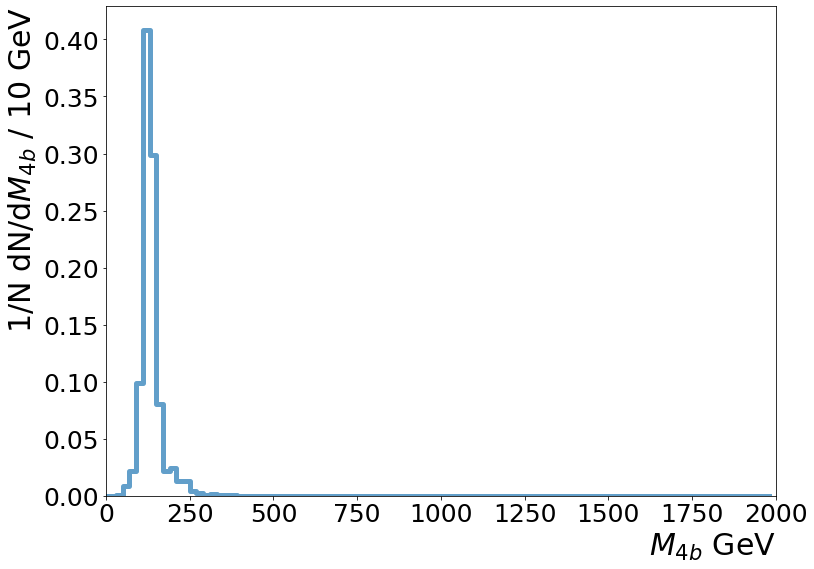

In [259]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
length = np.linspace(0,2000,101)
hist, bins = np.histogram(M_h1, bins=length)
plt.step(bins[:-1], hist.astype(np.float32) / hist.sum() ,where='mid',linewidth=5, alpha=0.7)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0,2000))
plt.xlabel("$M_{4b}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{4b}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
plt.show() 

In [ ]:
# event_list = [Event_List_herwig_angular_H,Event_List_pythia_default_H,#,Event_List_pythia_vincia_H,Event_List_pythia_dipole_H,Event_List_sherpa,
#               Event_List_herwig_angular_QCD,Event_List_pythia_default_QCD
#              ]
# #,Event_List_pythia_default_QCD,Event_List_pythia_vincia_QCD,Event_List_pythia_dipole_QCD,Event_List_sherpa_QCD]
# event_list_clustered = [[],[],[],[]]


# # event_list = [Event_List_herwig_angular_H, Event_List_pythia_default_H,Event_List_pythia_vincia_H,Event_List_pythia_dipole_H,
# #               Event_List_herwig_angular_QCD, Event_List_pythia_default_QCD,Event_List_pythia_vincia_QCD,Event_List_pythia_dipole_QCD]

# # event_list_clustered = [[],[],[],[],[],[],[],[]]


# for i, element in enumerate(event_list):
#     print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
#     ticks_1 = time.time()
#     for j in range(len(element)):

#         to_cluster = np.core.records.fromarrays(element[j], 
                                                
# #                                                 names="pT, eta, phi, mass, PID, Status",
# #                                                 formats = "f8, f8, f8, f8, f8, f8"
                                                
#                                                 names="pt, eta, phi, mass, PID, Status, Charge",
#                                                 formats = "f8, f8, f8, f8, f8, f8, f8"
#                                                )
#         pt_min = 20
#         sequence_cluster = pyjet.cluster(to_cluster, R = 1, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
#         jets_cluster = sequence_cluster.inclusive_jets(pt_min)
#         event_list_clustered[i].append(jets_cluster)
        
        
# #         if j == 5000:
# #             break
    
#     ticks_2 = time.time()
#     totaltime =  ticks_2 - ticks_1
#     print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

# Jet Trimmimng

In [260]:
event_list_clustered_trimmed = [[]]
for i, process in enumerate(event_list_clustered):
    print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    for j, jets in enumerate(process):
        jet_trimmed_list = []
        for N, jet_untrimmed in enumerate(jets):
            jet_trimmed = jet_trim(jet_untrimmed)[0]
            jet_trimmed_list.append(jet_trimmed)
        
        event_list_clustered_trimmed[i].append(jet_trimmed_list)
        
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Mon Jun 14 17:11:42 2021


IndexError: list index out of range

In [255]:
len(event_list_clustered_trimmed[0])

100000

# Print jets in the Nth event

In [ ]:
index = 0
N = 0

for i, jets in enumerate(event_list_clustered[index][N]):
    print("{}".format("No." +str(i)+" Jet's Information"))
    print(jets)
    print("-------------------------------------------------------------------------")
    print("{:^19} {:^20} ".format("Constituent's PID","Constituent's Four Momentum"))
    print("-------------------------------------------------------------------------")
    
    for constituent in jets: # get constituent in each "jet_element"
        print("{:^19} {} {:^19} ".format(int(constituent.PID), constituent, int(constituent.Charge)))
    print("-------------------------------------------------------------------------")

# Print the Truth Record in an Event

In [453]:
# # GenParticle = GenParticle_ppwz
GenParticle = GenParticle_herwig_angular_H



print("There are {} information in this event.".format(len(GenParticle.Status[0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 0## which event you want to print out
k = 0
for j in range(len(GenParticle.Status_At(index))):
    
    if GenParticle.Status_At(index)[j] == 2: ##Selet the Stable Final State Particles
#     if np.abs(GenParticle.PID_At(index)[j]) == 5 or np.abs(GenParticle.PID_At(index)[j]) == 5:

#     if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 24 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 24:
#         if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 23 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 23:

        print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.2}{:^8.2}{:^8.2}{:^8.2}".format( \
        j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
         GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))

#             k +=1
# print(k)

There are 1802 information in this event.
GenParticle Information
  #  Status   PID    M1     M2     D1     D2      PT     Eta     Phi     Mass  
 574    2    -313    482    -1    1050   1051    0.65    -1.0    -1.6    0.91  
 578    2     223    485    -1    1026   1027  1.5e+01   -3.6    -2.4    0.78  
 580    2    -323    486    -1    1029   1030    8.3     -1.3   -0.23    0.87  
 581    2     213    486    -1    1031   1032    2.6     -1.1   -0.39    0.62  
 582    2     213    488    -1    1084   1085    2.3     2.7     2.3     0.77  
 583    2    -213    488    -1    1086   1087    3.9     2.6     2.3     1.0   
 588    2   -20513   490    -1    1080   1081  1.5e+02   -0.3    -1.4    5.7   
 589    2     317    490    -1    1082   1083  2.4e+01   -0.3    -1.5    1.8   
 590    2     111    492    -1    1069   1070    5.3    -0.033   2.0     0.13  
 592    2     113    494    -1    1033   1034  3.5e+01  -0.013   1.9     0.8   
 593    2     113    494    -1    1035   1036  1.5e+01

# Detector Level

In [11]:
Jet_herwig_angular_H = BranchJet(herwig_angular_H)

In [12]:
def Jet_List(Jet):
    print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    k = 0
    Jet_list = []
    
    for N in range(Jet.length):
        
        Jet_list_tmp = []
        Jet_list_tmp_tmp = []


        Jet_list_tmp.append([Jet.PT_At(N),  Jet.Eta_At(N), \
                               Jet.Phi_At(N), Jet.Mass_At(N), \
                               Jet.Charge_At(N), Jet.BTag_At(N)
                              ])


        
        Jet_list_tmp = np.array(Jet_list_tmp)

        Jet_list_tmp = Jet_list_tmp[0]#[:,Jet_list_tmp[0][5,:]==1]
#         Jet_list_tmp = Jet_list_tmp[:,np.abs(Jet_list_tmp[4,:])!=12]
#         Jet_list_tmp = Jet_list_tmp[:,np.abs(Jet_list_tmp[4,:])!=14]
#         Jet_list_tmp = Jet_list_tmp[:,np.abs(Jet_list_tmp[4,:])!=16]
        
        Jet_list.append(Jet_list_tmp)

    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    return Jet_list

In [13]:
Jet_herwig_H = Jet_List(Jet_herwig_angular_H)

Tue Jun 08 15:39:58 2021
Time Cost : 0.0684 min


In [14]:
Jet_herwig_H[0]

array([[ 5.00812225e+02,  3.73847626e+02,  8.94229813e+01],
       [ 3.27681266e-02, -6.10102236e-01, -1.12148750e+00],
       [ 7.38322198e-01, -2.36418009e+00, -2.52158809e+00],
       [ 9.59987640e+01,  7.62778091e+01,  7.02130747e+00],
       [ 1.00000000e+00, -1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [15]:
Jet_herwig_H[0][:,Jet_herwig_H[0][5,:]==1]

array([[ 5.00812225e+02,  3.73847626e+02],
       [ 3.27681266e-02, -6.10102236e-01],
       [ 7.38322198e-01, -2.36418009e+00],
       [ 9.59987640e+01,  7.62778091e+01],
       [ 1.00000000e+00, -1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00]])

In [16]:
Jet_herwig_angular_H.BTag_At(0)

array([1, 1, 0], dtype=uint32)

# di-Jet Events' Selection From Truth Record

In [445]:
# M_J = [[],[],[],[],[],[],[],[],[],[]]
# PT_J = [[],[],[],[],[],[],[],[],[],[]]
# event_sele = [[],[],[],[],[],[],[],[],[],[]]
# angular_1 = [[],[],[],[],[],[],[],[],[],[]]
# angular_2 = [[],[],[],[],[],[],[],[],[],[]]

M_J1 = [[],[],[],[]]#,[],[],[],[]]
M_J2 = [[],[],[],[]]#,[],[],[],[]]
M_J3 = [[],[],[],[]]#,[],[],[],[]]
M_J4 = [[],[],[],[]]#,[],[],[],[]]
PT_J1 = [[],[],[],[]]#,[],[],[],[]]
PT_J2 = [[],[],[],[]]#,[],[],[],[]]
PT_J3 = [[],[],[],[]]#,[],[],[],[]]
PT_J4 = [[],[],[],[]]#,[],[],[],[]]
Mhh = [[],[],[],[]]#,[],[],[],[]]
event_sele = [[],[],[],[]]#,[],[],[],[]]


# M_J = [[],[]]
# PT_J = [[],[]]
# event_sele = [[],[]]
# angular_1 = [[],[]]
# angular_2 = [[],[]]

# for i, elementin enumerate(event_list_clustered):
for i,(element,element_trimmed) in enumerate(zip(event_list_clustered, event_list_clustered_trimmed)):
    trigger, two_jets  = 0, 0
    eta13, xhh = 0, 0
    
    for N in range(len(element)):
        
        """
        Trigger
        """
        if ET(element[N][0]) < 420 or element[N][0].mass < 35:
            trigger += 1
            continue
            
        """
        >= 2 jets
        """
        if len(element_trimmed[N]) < 2:
            two_jets += 1
            continue
            
        jet_1 = element_trimmed[N][0] #leading jet's information
        jet_2 = element_trimmed[N][1] #subleading jet's information
        
        
        if (jet_1.pt < 250) or (jet_2.pt < 250) :
            two_jets += 1
            continue
                
        if (abs(jet_1.eta) >= 2) or (jet_1.mass <= 50) :
            two_jets += 1
            continue
                
        if (abs(jet_2.eta) >= 2) or (jet_2.mass <= 50) :
            two_jets += 1
            continue
        
        if (jet_1.pt <= 450) :
            two_jets += 1
            continue
                
                    
        """
        |\Delta\eta| < 1.3
        """        
        if (abs(jet_1.eta - jet_2.eta) > 1.3) :
            eta13 += 1
            continue
                
                
        """
        X_HH < 1.6
        """        
        if XHH(jet_1,jet_2) >= 1.6 :
            xhh += 1
            continue
        
    
        M_J1[i].append(jet_1.mass)
        PT_J1[i].append(jet_1.pt)
        M_J2[i].append(jet_2.mass)
        PT_J2[i].append(jet_2.pt)
        Mhh[i].append(MJJ(jet_1,jet_2))

        event_sele[i].append(N)
        
    pass_trigger = len(element)-trigger
    pass_two_jets = len(element)-trigger-two_jets
    pass_eta13 = len(element)-trigger-two_jets-eta13
    pass_X_HH = len(element)-trigger-two_jets-eta13-xhh
        
    print("There are {} events passed trigger selection. eff: {:.3f}. ".format(pass_trigger, pass_trigger/len(element)))
    print("There are {} events passed 2 jets selection. eff: {:.3f}. ".format(pass_two_jets, pass_two_jets/len(element)))
    print("There are {} events passed |\Delta\eta| selection. eff: {:.3f}. ".format(pass_eta13, pass_eta13/len(element)))
    print("There are {} events passed XHH selection. eff: {:.3f}. ".format(pass_X_HH, pass_X_HH/len(element)))
    print("There are {} events passed all selection.".format(len(M_J1[i])))
    

There are 63900 events passed trigger selection. eff: 0.639. 
There are 27241 events passed 2 jets selection. eff: 0.272. 
There are 26243 events passed |\Delta\eta| selection. eff: 0.262. 
There are 2672 events passed XHH selection. eff: 0.027. 
There are 2672 events passed all selection.
There are 65925 events passed trigger selection. eff: 0.659. 
There are 29950 events passed 2 jets selection. eff: 0.299. 
There are 27976 events passed |\Delta\eta| selection. eff: 0.280. 
There are 2717 events passed XHH selection. eff: 0.027. 
There are 2717 events passed all selection.
There are 88511 events passed trigger selection. eff: 0.885. 
There are 19729 events passed 2 jets selection. eff: 0.197. 
There are 14045 events passed |\Delta\eta| selection. eff: 0.140. 
There are 46 events passed XHH selection. eff: 0.000. 
There are 46 events passed all selection.
There are 89459 events passed trigger selection. eff: 0.895. 
There are 22678 events passed 2 jets selection. eff: 0.227. 
There ar

## Example 1: Plot in differential number of event

In [447]:
def HIST(process, length, title, colors, linestyle,xpo=1,ypo=1):
    hist, bins = np.histogram(process, bins=length)
    plt.step(bins[:-1], hist.astype(np.float32) / hist.sum(), linestyle ,color= colors ,where='mid',linewidth=5, alpha=0.7, label=title[i])
#     plt.legend(bbox_to_anchor=(xpo, ypo),ncol=1,fontsize=30, edgecolor = "w",fancybox=False, framealpha=0)
    plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
# title = ["Herwig Angular", "Pythia default", "Pythia vincia", "Pythia dipole", "Sherpa", 
#          "Herwig Angular QCD", "Pythia default QCD", "Pythia vincia QCD", "Pythia dipole QCD","Sherpa QCD"]
# colors = ["green","red","darkred","blue","magenta",
#           "cyan","orange","darkred","darkblue","darkgreen"]
# linestyle = ["-","-.","--",":","X",
#              "D","s","^","H","h","*"]
# colors = ["green","red","darkred","blue","magenta"]
# linestyle = ["-","-.","--",":","X"]

title = ["Herwig angular (H->hh)","Pythia default (H->hh)",#"Pythia vincia (H->hh)", "Pythia dipole (H->hh)",
         "Herwig angular(QCD)", "Pythia default(QCD)"]#, "Pythia vincia(QCD)", "Pythia dipole(QCD)"]
colors = ["green","red","blue","purple"]#,
#           "cyan","black","Orange","lightblue"]


linestyle = ["-","-.",":","--"]#,
#              "--","--",":",":"]


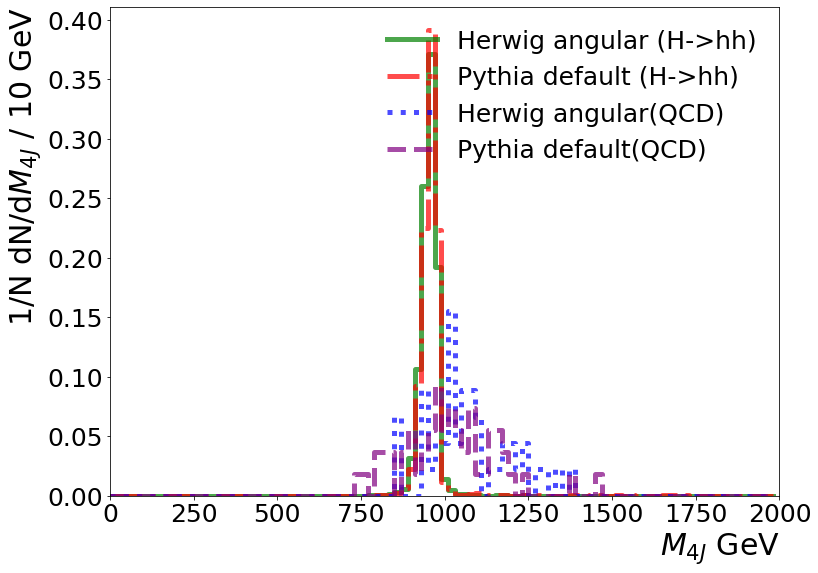

In [448]:
M_bbbb = Mhh

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_bbbb):
    length = np.linspace(0,2000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,2000))
    plt.xlabel("$M_{4J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{4J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show() 

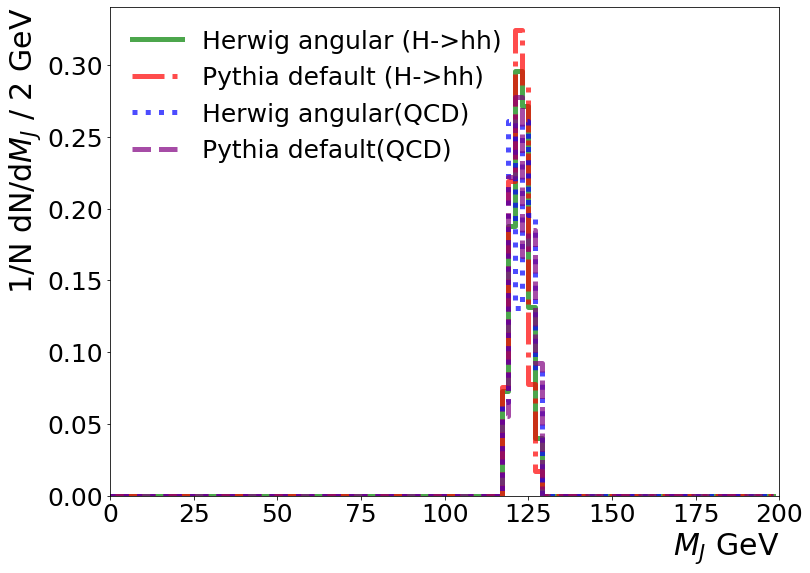

In [449]:
M_j = M_J1

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,200,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ / 2 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()    
    

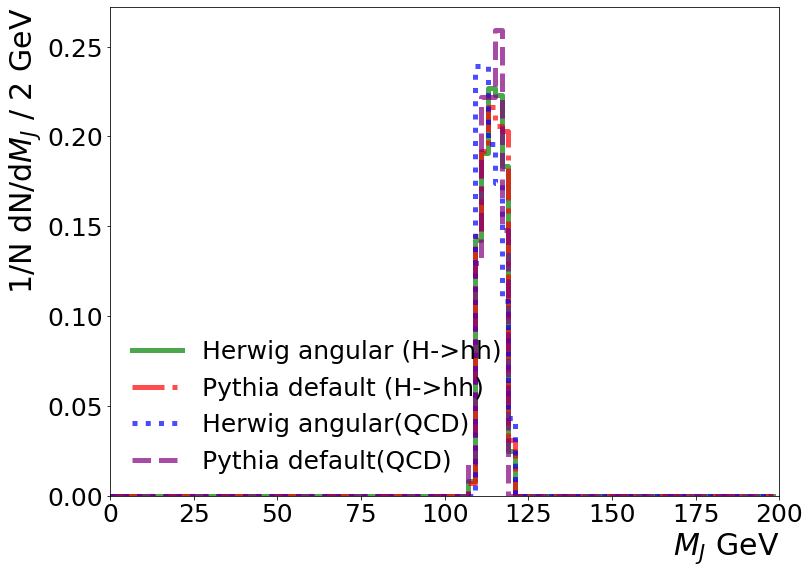

In [450]:
M_j = M_J2

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,200,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ / 2 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()  

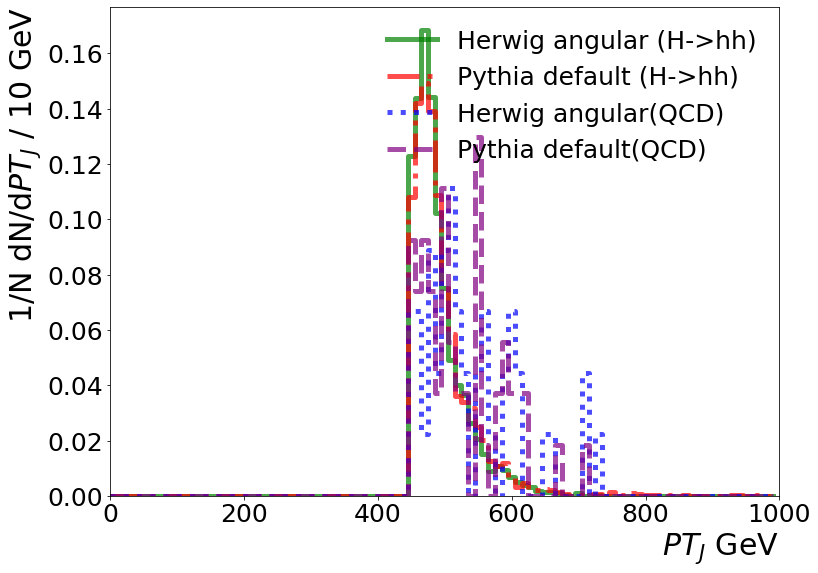

In [451]:
PT_j = PT_J1

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(PT_j):
    length = np.linspace(0,1000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,1000))
    plt.xlabel("$PT_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$PT_{J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()    

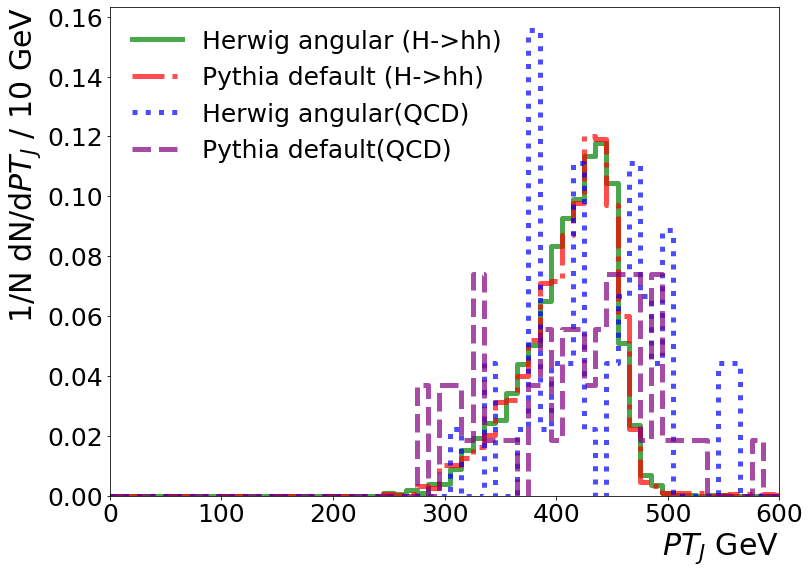

In [452]:
PT_j = PT_J2

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(PT_j):
    length = np.linspace(0,1000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,1000))
    plt.xlabel("$PT_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.xlim((0.,600))
plt.ylabel("1/N dN/d$PT_{J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()   

# JSS

In [124]:
# import jet_trimming 
# import JSS 
from itertools import combinations


def jet_trim(jet0, pt_cut= 0.03, R1 = 0.2):
    # Define a cut threshold that the subjets have to meet (i.e. 3% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = pyjet.cluster(jet0.constituents_array(), R=R1, p=1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    subjet_array = subjets.inclusive_jets()
    j0 = []
    if (subjet_array[0].pt >= jet0_cut):
        for ij, subjet in enumerate(subjet_array):
            if subjet.pt < jet0_cut:
                # subjet doesn't meet the percentage cut on the original jet pT
                continue
            if subjet.pt >= jet0_cut:
                # Get the subjets pt, eta, phi constituents
                subjet_data = subjet.constituents_array()
                j0.append(subjet_data)
    else:
        j0 = subjet_array[0].constituents_array()*0
    jet = j0[0]
    for i, subjet in enumerate(j0):
        if i==0 :
            continue
        jet = np.append(jet, subjet)
        
    sequence = pyjet.cluster(jet, R=1.2, p=-1)
    jet = sequence.inclusive_jets()
    return jet



def CalcDeltaR(j1, j2):
    eta1 = j1.eta
    phi1 = j1.phi
    eta2 = j2.eta
    phi2 = j2.phi

    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def CalcDeltaRArray(p, a):
    dEta = p['eta'] - \
        a['eta'].repeat(p.shape[0]).reshape(a.shape[0], p.shape[0])
    dPhi = np.abs(p['phi'] - a['phi'].repeat(p.shape[0]
                                             ).reshape(a.shape[0], p.shape[0]))
    mask = dPhi > np.pi
    dPhi[mask] *= -1
    dPhi[mask] += 2 * np.pi
    return (dPhi**2 + dEta**2)**0.5

def t0(jet):
    return sum(p.pt * CalcDeltaR(p, jet) for p in jet.constituents())

def tn(jet, n): #t1 t2 t3 t21 t32
    assert n >= 0
    if n == 0:
        return t0(jet)
    particles = jet.constituents_array()
    if len(particles) < n:
        return -1
    subjets = pyjet.cluster(particles, R=1.0, p=1).exclusive_jets(n)
    subjets_array = [subjet.constituents_array() for subjet in subjets]
    wta_axes = [a[np.argmax(a['pT'])] for a in subjets_array]
    wta_axes = np.array(wta_axes, dtype=subjets_array[0].dtype)
    return np.sum(particles['pT']*CalcDeltaRArray(particles, wta_axes).min(axis=0)) / t0(jet)

def CalcEECorr(jet, n=1, beta=1.0):

    assert n == 2 or n == 3, 'fn must be in [2, 3] but is n'

    jet_particles = jet.constituents()

    if len(jet_particles) < n:
        return -1

    currentSum = 0

    if n == 2:
        for p1, p2 in combinations(jet_particles, 2):
            # get the terms of the triplet at hand
            pt1 = p1.pt
            pt2 = p2.pt
            dr12 = CalcDeltaR(p1, p2)

            # calculate the partial contribution
            thisterm = pt1*pt2 * (dr12)**beta

            # sum it up
            currentSum += thisterm

        eec = currentSum/(jet.pt)**2

    elif n == 3:
        dr = {(p1, p2): CalcDeltaR(p1, p2)
              for p1, p2 in combinations(jet_particles, 2)}
        for p1, p2, p3 in combinations(jet_particles, 3):
            # get the terms of the triplet at hand
            dr12 = dr[(p1, p2)]
            dr13 = dr[(p1, p3)]
            dr23 = dr[(p2, p3)]

            # calculate the partial contribution
            thisterm = p1.pt*p2.pt*p3.pt * (dr12*dr13*dr23)**beta

            # sum it up
            currentSum += thisterm

        eec = currentSum/(jet.pt)**3
    return eec

In [125]:
# ###################################################################################
  
# print("Selection and Trimming")
# print("\n")    
# print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
# ticks_1 = time.time()
    

# for i, element in enumerate(event_list_clustered):
#     for N in range(len(element)):

#         if len(element[N]) >= 2: # at least two jets in this event.
#             jet_1_untrimmed = element[N][0] #leading jet's information
#             jet_2_untrimmed = element[N][1] #subleading jet's information
        
#     #         if jet_1_untrimmed.pt < 300 or jet_1_untrimmed.pt > 500: 
#     #             continue

#             t1 = JSS.tn(jet_1_untrimmed, n=1)
#             t2 = JSS.tn(jet_1_untrimmed, n=2)
#             t21_untrimmed = t2 / t1 if t1 > 0.0 else 0.0

#             ee2 = JSS.CalcEECorr(jet_1_untrimmed, n=2, beta=1.0)
#             ee3 = JSS.CalcEECorr(jet_1_untrimmed, n=3, beta=1.0)
#             d21_untrimmed = ee3/(ee2**3) if ee2>0 else 0
#             d22_untrimmed = ee3**2/((ee2**2)**3) if ee2>0 else 0
#             c21_untrimmed = ee3/(ee2**2) if ee2>0 else 0
#             c22_untrimmed = ee3**2/((ee2**2)**2) if ee2>0 else 0 
            
#             M_J1[i].append(jet_1_untrimmed.mass)
#             PT_J1[i].append(jet_1_untrimmed.pt)
#             T21_1[i].append(t21_untrimmed)
#             D21_1[i].append(d21_untrimmed)
#             D22_1[i].append(d22_untrimmed)
#             C21_1[i].append(c21_untrimmed)
#             C22_1[i].append(c22_untrimmed)
            
            
#             t1 = JSS.tn(jet_2_untrimmed, n=1)
#             t2 = JSS.tn(jet_2_untrimmed, n=2)
#             t21_untrimmed = t2 / t1 if t1 > 0.0 else 0.0

#             ee2 = JSS.CalcEECorr(jet_2_untrimmed, n=2, beta=1.0)
#             ee3 = JSS.CalcEECorr(jet_2_untrimmed, n=3, beta=1.0)
#             d21_untrimmed = ee3/(ee2**3) if ee2>0 else 0
#             d22_untrimmed = ee3**2/((ee2**2)**3) if ee2>0 else 0
#             c21_untrimmed = ee3/(ee2**2) if ee2>0 else 0
#             c22_untrimmed = ee3**2/((ee2**2)**2) if ee2>0 else 0 
            
#             M_J2[i].append(jet_2_untrimmed.mass)
#             PT_J2[i].append(jet_2_untrimmed.pt)
#             T21_2[i].append(t21_untrimmed)
#             D21_2[i].append(d21_untrimmed)
#             D22_2[i].append(d22_untrimmed)
#             C21_2[i].append(c21_untrimmed)
#             C22_2[i].append(c22_untrimmed)
            
            

#             ## Jet Trimming
#             jet_1_trimmed = jet_trimming.jet_trim(jet_1_untrimmed)[0]   #trimming jet's information
#             jet_2_trimmed = jet_trimming.jet_trim(jet_2_untrimmed)[0]   #trimming jet's information

#     #         if jet_1_trimmed.pt < 300 or jet_1_trimmed.pt > 500: 
#     #             continue


#             t1 = JSS.tn(jet_1_trimmed, n=1)
#             t2 = JSS.tn(jet_1_trimmed, n=2)
#             t21_trimmed = t2 / t1 if t1 > 0.0 else 0.0

#             ee2 = JSS.CalcEECorr(jet_1_trimmed, n=2, beta=1.0)
#             ee3 = JSS.CalcEECorr(jet_1_trimmed, n=3, beta=1.0)
#             d21_trimmed = ee3/(ee2**3) if ee2>0 else 0
#             d22_trimmed = ee3**2/((ee2**2)**3) if ee2>0 else 0
#             c21_trimmed = ee3/(ee2**2) if ee2>0 else 0
#             c22_trimmed = ee3**2/((ee2**2)**2) if ee2>0 else 0 
            
#             M_J1_trimmed[i].append(jet_1_trimmed.mass)
#             PT_J1_trimmed[i].append(jet_1_trimmed.pt)
#             T21_1_trimmed[i].append(t21_trimmed)
#             D21_1_trimmed[i].append(d21_trimmed)
#             D22_1_trimmed[i].append(d22_trimmed)
#             C21_1_trimmed[i].append(c21_trimmed)
#             C22_1_trimmed[i].append(c22_trimmed)
            
            
#             t1 = JSS.tn(jet_2_trimmed, n=1)
#             t2 = JSS.tn(jet_2_trimmed, n=2)
#             t21_trimmed = t2 / t1 if t1 > 0.0 else 0.0

#             ee2 = JSS.CalcEECorr(jet_2_trimmed, n=2, beta=1.0)
#             ee3 = JSS.CalcEECorr(jet_2_trimmed, n=3, beta=1.0)
#             d21_trimmed = ee3/(ee2**3) if ee2>0 else 0
#             d22_trimmed = ee3**2/((ee2**2)**3) if ee2>0 else 0
#             c21_trimmed = ee3/(ee2**2) if ee2>0 else 0
#             c22_trimmed = ee3**2/((ee2**2)**2) if ee2>0 else 0 
            
#             M_J2_trimmed[i].append(jet_2_trimmed.mass)
#             PT_J2_trimmed[i].append(jet_2_trimmed.pt)
#             T21_2_trimmed[i].append(t21_trimmed)
#             D21_2_trimmed[i].append(d21_trimmed)
#             D22_2_trimmed[i].append(d22_trimmed)
#             C21_2_trimmed[i].append(c21_trimmed)
#             C22_2_trimmed[i].append(c22_trimmed)


# totaltime =  ticks_2 - ticks_1
# print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))


# ###################################################################################

In [126]:
path2 = "/home/u5/Universality_DiHiggs/Data_High_Level_Features/"

herwig_def_H = pd.read_csv(path2 + "herwig_ang_H_1.csv")
herwig_def_QCD = pd.read_csv(path2 + "herwig_ang_QCD_1.csv")
pythia_def_H = pd.read_csv(path2 + "pythia_def_H_1.csv")
pythia_def_QCD = pd.read_csv(path2 + "pythia_def_QCD_1.csv")
pythia_vin_H = pd.read_csv(path2 + "pythia_vin_H_1.csv")
pythia_vin_QCD = pd.read_csv(path2 + "pythia_vin_QCD_1.csv")
# pythia_dip = pd.read_csv(path2 + "pythia_dip_H_1.csv")
# pythia_dip = pd.read_csv(path2 + "pythia_dip_QCD_1_untrimmed.csv")

features = ["GEN","SHO","PRO",
            "MJJ_0",
            "MJ1_0","PTJ1_0","t211_0","D211_0","D221_0","C211_0","C221_0",
            "MJ2_0","PTJ2_0","t212_0","D212_0","D222_0","C212_0","C222_0",
            "MJJ",
            "MJ1","PTJ1","t211","D211","D221","C211","C221",
            "MJ2","PTJ2","t212","D212","D222","C212","C222",
            "eventindex"
           ]

In [127]:
def Combine(feature):

    feature_H = [herwig_def_H[feature],pythia_def_H[feature],pythia_vin_H[feature]]

    feature_QCD = [herwig_def_QCD[feature],pythia_def_QCD[feature],pythia_vin_QCD[feature]]

    H_QCD =  [herwig_def_H[feature],pythia_def_H[feature],pythia_vin_H[feature],
              herwig_def_QCD[feature],pythia_def_QCD[feature],pythia_vin_QCD[feature]
             ]
    
    return feature_H, feature_QCD, H_QCD

In [128]:
def HIST(process, length, title, colors, linestyle,xpo=1,ypo=1):
    hist, bins = np.histogram(process, bins=length)
    plt.step(bins[:-1], hist.astype(np.float32) / hist.sum(), linestyle ,color= colors ,where='mid',linewidth=5, alpha=0.7, label=title[i])
#     plt.legend(bbox_to_anchor=(xpo, ypo),ncol=1,fontsize=30, edgecolor = "w",fancybox=False, framealpha=0)
    plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
# title = ["Herwig Angular", "Pythia default", "Pythia vincia", "Pythia dipole", "Sherpa", 
#          "Herwig Angular QCD", "Pythia default QCD", "Pythia vincia QCD", "Pythia dipole QCD","Sherpa QCD"]
# colors = ["green","red","darkred","blue","magenta",
#           "cyan","orange","darkred","darkblue","darkgreen"]
# linestyle = ["-","-.","--",":","X",
#              "D","s","^","H","h","*"]
# colors = ["green","red","darkred","blue","magenta"]
# linestyle = ["-","-.","--",":","X"]

title = ["Herwig angular (H->hh)","Pythia default (H->hh)","Pythia vincia (H->hh)",#"Pythia dipole (H->hh)",
         "Herwig angular(QCD)", "Pythia default(QCD)", "Pythia vincia(QCD)" #, "Pythia dipole(QCD)"
        ]
colors = ["green","red","blue",#"purple",
          "cyan","black","Orange"#,"lightblue"
         ]


linestyle = ["-","-.",":",#"--",
             "--","--",":"#,":"
            ]



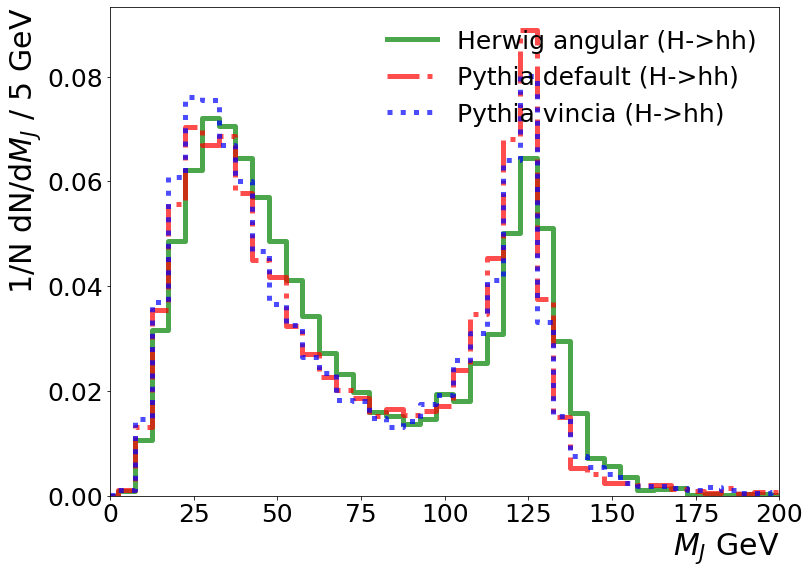

In [129]:
Mjj= Combine("MJ1_0")[0]

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(Mjj):
    length = np.linspace(0,1000,201)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ / 5 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()  

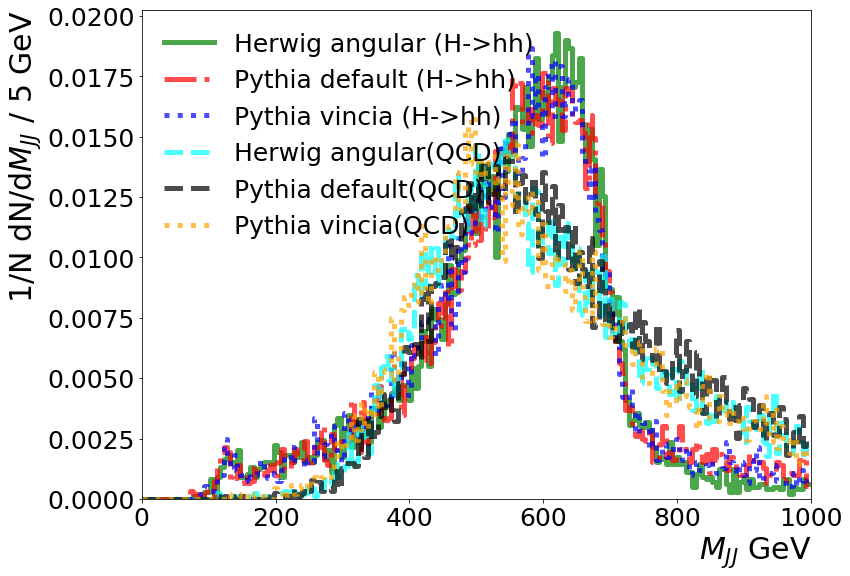

In [130]:
Mjj= Combine("MJJ_0")[2]

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(Mjj):
    length = np.linspace(0,1000,201)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,1000))
    plt.xlabel("$M_{JJ}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{JJ}$ / 5 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()  

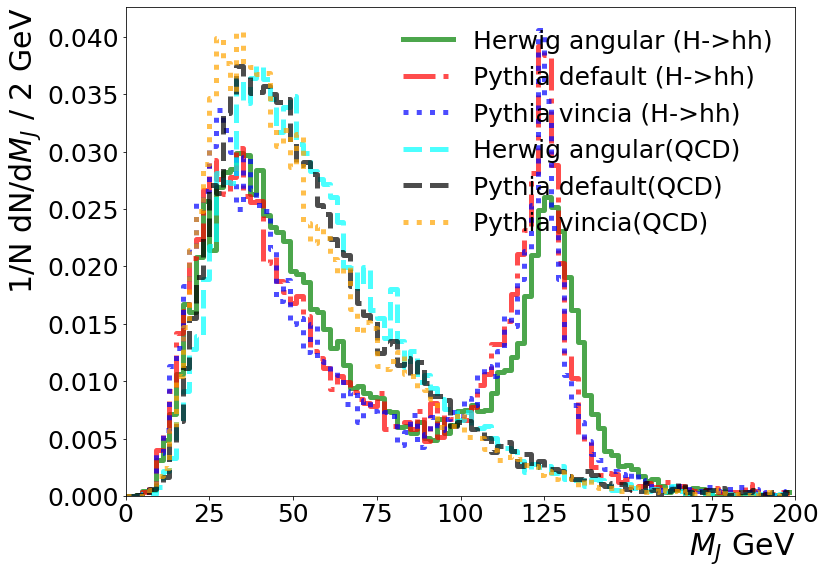

In [131]:
M_j = Combine("MJ1_0")[2]


fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,200,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ / 2 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()  

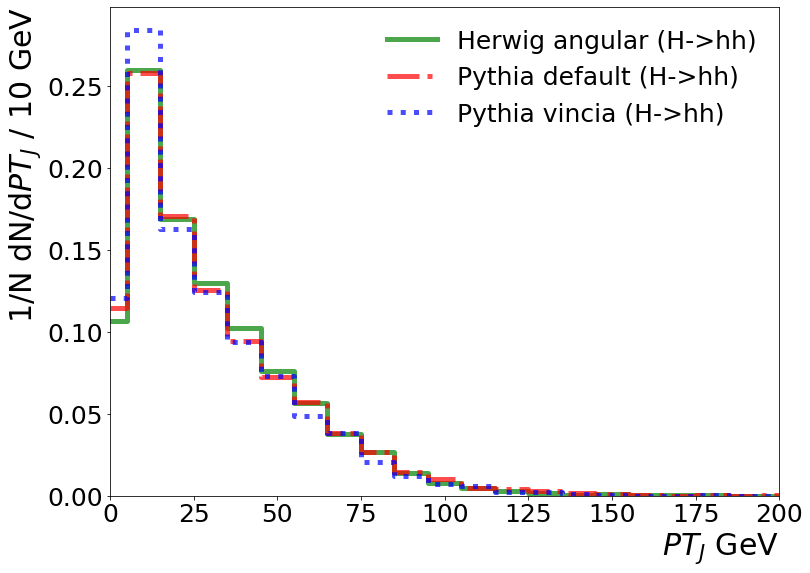

In [132]:
PT_j =  Combine("MJ2")[1]

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(PT_j):
    length = np.linspace(0,1000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$PT_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$PT_{J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show() 

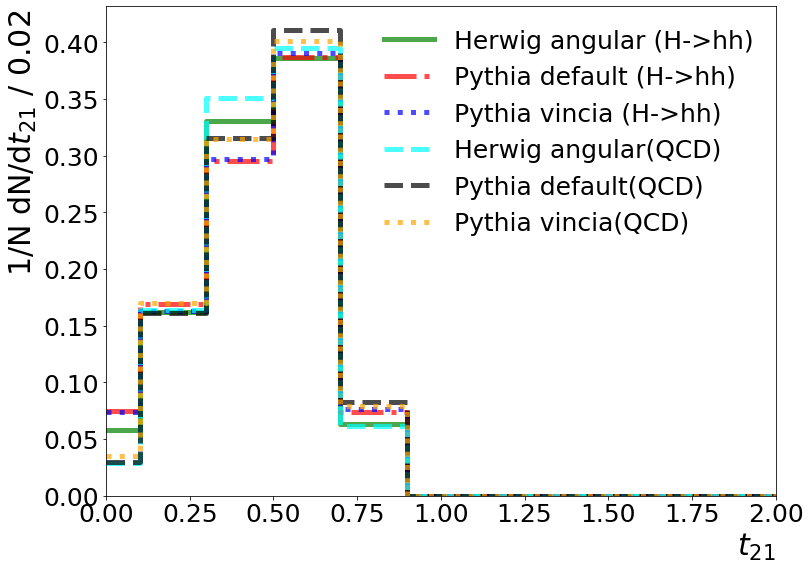

In [133]:
T21 = Combine("t212")[2]

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(T21):
    length = np.linspace(0,100,501)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,2))
    plt.xlabel("$t_{21}$", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$t_{21}$ / 0.02 ", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()  